In [1]:
# %reload_ext lab_black

import pandas as pd
import numpy as np
from collections import Counter
import pandas as pd
# import lightgbm as lgb
from sklearn.datasets import load_breast_cancer, load_boston, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from nltk import tokenize
from datetime import datetime
import nltk
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from numba import jit, prange
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.models import SequenceTagger
from flair.data import Sentence
from segtok.segmenter import split_single
from statistics import mean
import math

sid = SentimentIntensityAnalyzer()
classifier = TextClassifier.load("en-sentiment")

pd.options.display.max_columns = 999

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/dapoadegbile/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


2021-04-23 12:15:02,767 loading file /Users/dapoadegbile/.flair/models/sentiment-en-mix-distillbert_4.pt


In [2]:
final_df = pd.read_csv("../00_data/final_data_Apr10.csv")

In [3]:
final_df.tail()

,Unnamed: 0,viewCount,likeCount,dislikeCount,num_days_since_pub,viewcounts_weighted,like_count_weighted,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,videoTitleSentimentScore_vader_pos,videoTitleSentimentScore_vader_com,captionSentimentScore_vader_pos,captionSentimentScore_vader_neg,captionSentimentScore_vader_com,falir_videoTitle_score,caption_list_split_by_nvidia_10words_flairscores,caption_list_split_by_nvidia_20words_flairscores,caption_list_split_by_nvidia_35words_flairscores,caption_list_split_by_nvidia_10words_vaderscores,caption_list_split_by_nvidia_20words_vaderscores,caption_list_split_by_nvidia_35words_vaderscores,msft,amd,ndaq,intel,qualcomm,apple,pred_24,pred_48,pred_72,percent_change_24,percent_change_48,percent_change_72,action_96
793,793,856113.00,44029.64,966.76,122.96,13053.192061,783.768560,19.098946,0.958856,0.958856,12706.300806,0.337000,-0.228971,0.128150,0.041150,0.998830,-0.26684,0.070750,0.196550,0.148350,0.107000,0.116300,0.119550,235.820007,78.510002,147.500000,64.010002,132.589996,122.160004,3.403381,3.222672,3.085449,3.521059,3.521059,3.521059,buy
794,794,857090.08,44060.44,968.20,123.24,12421.798377,741.488729,16.643729,0.958569,0.958569,12114.157836,0.337000,-0.228971,0.128150,0.041150,0.998830,-0.26684,0.070750,0.196550,0.148350,0.107000,0.116300,0.119550,235.820007,78.510002,147.500000,64.010002,132.589996,122.160004,3.403381,3.222672,3.085449,3.521059,3.521059,3.521059,buy
795,795,1007232.96,50007.56,1136.76,131.08,13108.659614,769.382933,17.351029,0.959595,0.959595,12782.911467,0.362333,-0.132087,0.129850,0.041050,0.999175,-0.18692,0.086800,0.200750,0.131700,0.110579,0.114200,0.117800,235.820007,78.510002,147.500000,64.010002,132.589996,122.160004,3.269714,3.814987,4.211792,3.521059,3.521059,3.521059,buy
796,796,857715.44,44094.92,969.28,123.28,12679.298844,765.462176,17.285382,0.959735,0.959735,12362.124996,0.337000,-0.241762,0.130600,0.040850,0.999190,-0.26676,0.066500,0.202500,0.126650,0.108632,0.117400,0.119650,241.669998,80.529999,150.460007,63.735001,134.915497,123.400002,0.613037,1.067802,1.536865,0.723444,0.723444,0.723444,hold
797,797,776461.96,42458.44,912.12,107.44,13368.439765,793.072442,16.390290,0.965090,0.965090,13062.621538,0.290000,-0.106757,0.127167,0.041944,0.999189,-0.05364,0.009111,0.166778,0.104944,0.108706,0.115778,0.121111,241.959000,81.035004,150.770004,64.110001,137.839996,122.870003,0.095581,-0.311607,-0.738647,-0.001811,-0.001811,-0.001811,hold


In [4]:
y = final_df.iloc[:, -1]
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(list(le.classes_))
print(le.transform(["buy", "hold", "sell"]))

['buy', 'hold', 'sell']
[0 1 2]


In [5]:
final_df.action_96.unique()

array(['buy', 'hold', 'sell'], dtype=object)

In [6]:
final_df

,Unnamed: 0,viewCount,likeCount,dislikeCount,num_days_since_pub,viewcounts_weighted,like_count_weighted,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,videoTitleSentimentScore_vader_pos,videoTitleSentimentScore_vader_com,captionSentimentScore_vader_pos,captionSentimentScore_vader_neg,captionSentimentScore_vader_com,falir_videoTitle_score,caption_list_split_by_nvidia_10words_flairscores,caption_list_split_by_nvidia_20words_flairscores,caption_list_split_by_nvidia_35words_flairscores,caption_list_split_by_nvidia_10words_vaderscores,caption_list_split_by_nvidia_20words_vaderscores,caption_list_split_by_nvidia_35words_vaderscores,msft,amd,ndaq,intel,qualcomm,apple,pred_24,pred_48,pred_72,percent_change_24,percent_change_48,percent_change_72,action_96
0,0,9.644912e+05,40463.448276,1070.793103,15.241379,84589.429291,3723.437055,97.624292,0.971347,0.971347,82587.974284,0.277400,-0.014347,0.122280,0.046480,0.998404,-0.042517,0.069875,-0.045000,-0.159125,0.099091,0.093435,0.096708,206.179993,81.839996,123.529999,51.009998,115.470001,113.019997,-0.002991,0.000267,4.447388,0.000000,0.000000,4.444195,buy
1,1,1.045160e+06,44341.740000,1192.020000,17.400000,63909.437389,2967.019734,89.903678,0.969618,0.969618,62169.305249,0.319667,-0.081008,0.121952,0.042571,0.998157,0.110200,0.125850,0.059200,-0.075550,0.099556,0.099421,0.100650,206.179993,81.839996,123.529999,51.009998,115.470001,113.019997,0.016296,0.003418,4.496948,0.000000,0.000000,4.444195,buy
2,2,1.077168e+06,46144.080000,1244.080000,18.640000,64870.463707,3002.939559,91.268385,0.967561,0.967561,63097.778622,0.307000,-0.004042,0.120857,0.039333,0.998038,0.269840,0.166950,0.157000,-0.018450,0.096176,0.097526,0.098400,206.179993,81.839996,123.529999,51.009998,115.470001,113.019997,-1.561768,-2.512115,1.673584,0.000000,0.000000,4.444195,buy
3,3,1.077747e+06,46178.200000,1245.080000,18.680000,65211.201800,3031.484044,92.005868,0.969667,0.969667,63429.337457,0.319667,-0.082817,0.121143,0.042048,0.998081,0.190160,0.090150,0.092750,-0.072100,0.096667,0.098474,0.098000,206.179993,81.839996,123.529999,51.009998,115.470001,113.019997,0.000488,0.000504,4.457031,0.000000,0.000000,4.444195,buy
4,4,1.080107e+06,46259.160000,1248.360000,18.960000,65479.014739,3024.847456,92.011051,0.969174,0.969174,63687.150884,0.319667,-0.022800,0.118905,0.041810,0.997852,0.190000,0.126750,0.101050,-0.098250,0.096176,0.095842,0.097150,206.179993,81.839996,123.529999,51.009998,115.470001,113.019997,0.720581,0.898804,5.704468,0.000000,0.000000,4.444195,buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,793,8.561130e+05,44029.640000,966.760000,122.960000,13053.192061,783.768560,19.098946,0.958856,0.958856,12706.300806,0.337000,-0.228971,0.128150,0.041150,0.998830,-0.266840,0.070750,0.196550,0.148350,0.107000,0.116300,0.119550,235.820007,78.510002,147.500000,64.010002,132.589996,122.160004,3.403381,3.222672,3.085449,3.521059,3.521059,3.521059,buy
794,794,8.570901e+05,44060.440000,968.200000,123.240000,12421.798377,741.488729,16.643729,0.958569,0.958569,12114.157836,0.337000,-0.228971,0.128150,0.041150,0.998830,-0.266840,0.070750,0.196550,0.148350,0.107000,0.116300,0.119550,235.820007,78.510002,147.500000,64.010002,132.589996,122.160004,3.403381,3.222672,3.085449,3.521059,3.521059,3.521059,buy
795,795,1.007233e+06,50007.560000,1136.760000,131.080000,13108.659614,769.382933,17.351029,0.959595,0.959595,12782.911467,0.362333,-0.132087,0.129850,0.041050,0.999175,-0.186920,0.086800,0.200750,0.131700,0.110579,0.114200,0.117800,235.820007,78.510002,147.500000,64.010002,132.589996,122.160004,3.269714,3.814987,4.211792,3.521059,3.521059,3.521059,buy
796,796,8.577154e+05,44094.920000,969.280000,123.280000,12679.298844,765.462176,17.285382,0.959735,0.959735,12362.124996,0.337000,-0.241762,0.130600,0.040850,0.999190,-0.266760,0.066500,0.202500,0.126650,0.108632,0.

In [7]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,

In [8]:
def display_scores(scores):
    print(
        "Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(
            scores, np.mean(scores), np.std(scores)
        )
    )


def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


def algorithm_pipeline(
    X_train_data,
    X_test_data,
    y_train_data,
    y_test_data,
    model,
    param_grid,
    cv=10,
    scoring_fit="accuracy",
    do_probabilities=False,
):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        scoring=scoring_fit,
        verbose=2,
    )
    fitted_model = gs.fit(X_train_data, y_train_data)

    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)

    return fitted_model, pred

In [9]:
final_df.drop(
    [
        "Unnamed: 0",
        "msft",
        "amd",
        "ndaq",
        "intel",
        "qualcomm",
        "apple",
        "pred_24",
        "pred_48",
        "pred_72",
        "action_96",
        "percent_change_24",
        "percent_change_48",
        "percent_change_72",
    ],
    axis=1,
)

,viewCount,likeCount,dislikeCount,num_days_since_pub,viewcounts_weighted,like_count_weighted,dislike_count_weighted,like_dislike_ratio,weighted_like_dislike_ratio,like_dislike_ratio_by_viewcounts_weighted,videoTitleSentimentScore_vader_pos,videoTitleSentimentScore_vader_com,captionSentimentScore_vader_pos,captionSentimentScore_vader_neg,captionSentimentScore_vader_com,falir_videoTitle_score,caption_list_split_by_nvidia_10words_flairscores,caption_list_split_by_nvidia_20words_flairscores,caption_list_split_by_nvidia_35words_flairscores,caption_list_split_by_nvidia_10words_vaderscores,caption_list_split_by_nvidia_20words_vaderscores,caption_list_split_by_nvidia_35words_vaderscores
0,9.644912e+05,40463.448276,1070.793103,15.241379,84589.429291,3723.437055,97.624292,0.971347,0.971347,82587.974284,0.277400,-0.014347,0.122280,0.046480,0.998404,-0.042517,0.069875,-0.045000,-0.159125,0.099091,0.093435,0.096708
1,1.045160e+06,44341.740000,1192.020000,17.400000,63909.437389,2967.019734,89.903678,0.969618,0.969618,62169.305249,0.319667,-0.081008,0.121952,0.042571,0.998157,0.110200,0.125850,0.059200,-0.075550,0.099556,0.099421,0.100650
2,1.077168e+06,46144.080000,1244.080000,18.640000,64870.463707,3002.939559,91.268385,0.967561,0.967561,63097.778622,0.307000,-0.004042,0.120857,0.039333,0.998038,0.269840,0.166950,0.157000,-0.018450,0.096176,0.097526,0.098400
3,1.077747e+06,46178.200000,1245.080000,18.680000,65211.201800,3031.484044,92.005868,0.969667,0.969667,63429.337457,0.319667,-0.082817,0.121143,0.042048,0.998081,0.190160,0.090150,0.092750,-0.072100,0.096667,0.098474,0.098000
4,1.080107e+06,46259.160000,1248.360000,18.960000,65479.014739,3024.847456,92.011051,0.969174,0.969174,63687.150884,0.319667,-0.022800,0.118905,0.041810,0.997852,0.190000,0.126750,0.101050,-0.098250,0.096176,0.095842,0.097150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
793,8.561130e+05,44029.640000,966.760000,122.960000,13053.192061,783.768560,19.098946,0.958856,0.958856,12706.300806,0.337000,-0.228971,0.128150,0.041150,0.998830,-0.266840,0.070750,0.196550,0.148350,0.107000,0.116300,0.119550
794,8.570901e+05,44060.440000,968.200000,123.240000,12421.798377,741.488729,16.643729,0.958569,0.958569,12114.157836,0.337000,-0.228971,0.128150,0.041150,0.998830,-0.266840,0.070750,0.196550,0.148350,0.107000,0.116300,0.119550
795,1.007233e+06,50007.560000,1136.760000,131.080000,13108.659614,769.382933,17.351029,0.959595,0.959595,12782.911467,0.362333,-0.132087,0.129850,0.041050,0.999175,-0.186920,0.086800,0.200750,0.131700,0.110579,0.114200,0.117800
796,8.577154e+05,44094.920000,969.280000,123.280000,12679.298844,765.462176,17.285382,0.959735,0.959735,12362.124996,0.337000,-0.241762,0.130600,0.040850,0.999190,-0.266760,0.066500,0.202500,0.126650,0.108632,0.117400,0.119650


In [10]:
np.unique(np.array(final_df.action_96), return_counts=True)

(array(['buy', 'hold', 'sell'], dtype=object), array([181, 451, 166]))

In [11]:
count = np.unique(y, axis=0, return_counts=True)[1]

<BarContainer object of 3 artists>

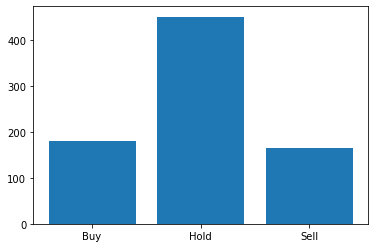

In [12]:
classes = ["Buy", "Hold", "Sell"]

plt.bar(classes, count)

In [13]:
# split x and y
X = final_df.drop(
    [
        "Unnamed: 0",
        "msft",
        "amd",
        "ndaq",
        "intel",
        "qualcomm",
        "apple",
        "pred_24",
        "pred_48",
        "pred_72",
        "action_96",
        "percent_change_24",
        "percent_change_48",
        "percent_change_72",
    ],
    axis=1,
)
y = final_df.iloc[:, -1]

# create lables
le = LabelEncoder()
le.fit(y)
y = le.transform(y)
print(list(le.classes_))
print(le.transform(["buy", "hold", "sell"]))
# Scaling using the Standard Scaler
sc_1 = StandardScaler()
sc_1.fit(X)
X_1 = pd.DataFrame(sc_1.fit_transform(X))
column_names = list(X.columns)
X_1.set_axis(column_names, axis=1, inplace=True)

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(
    X_1, y, test_size=0.30, random_state=0
)

['buy', 'hold', 'sell']
[0 1 2]


In [14]:
y_train

array([1, 2, 0, 2, 2, 1, 1, 0, 0, 1, 2, 1, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       2, 1, 2, 0, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1,
       1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 2, 2, 1, 0,
       2, 1, 0, 2, 0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 1, 0, 1, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 1,
       2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1, 1, 2, 1, 1,
       2, 0, 2, 1, 0, 2, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0,

In [69]:
param_grid = { 'tol' : [1e-4, 1e-5, 1e-6],
               'C'   : [1.0, 2.0, 3.0, 4.0, 5.0],
               'multi_class' : ['auto', 'ovr'] }

In [70]:
from sklearn.linear_model import LogisticRegression

# param_grid = {'tol' : [1e-4, 1e-5, 1e-6]}

model = LogisticRegression(solver='liblinear')

In [71]:
model, pred = algorithm_pipeline(
    X_train, X_test, y_train, y_test, model, param_grid, cv=5)

pram_best = model.best_params_
# print(model.best_score_)
# print(model.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [72]:
print(model.best_score_)


0.6453024453024454


In [73]:
print(model.best_params_)

{'C': 3.0, 'multi_class': 'auto', 'tol': 0.0001}
